tgb - 11/20/2019 - The goal of this network is to code a custom interpolation layer to solve the bias where the NN misses on the upwards shift of the convective tendencies.  
1) Create a look-up table where from the lowest-level temperature, we can extract a Carnot vertical coordinate.  
2) Code up the interpolation layer in both directions in numpy  
3) Transfer that layer in tensorflow  
4) Try a few test networks using 101/100 and 104/103

# 0) Imports

In [1]:
from cbrain.imports import *
from cbrain.data_generator import *
from cbrain.cam_constants import *
from cbrain.losses import *
from cbrain.utils import limit_mem
from cbrain.layers import *
from cbrain.data_generator import DataGenerator
import tensorflow as tf
import tensorflow.math as tfm
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import xarray as xr
import numpy as np
from cbrain.model_diagnostics import ModelDiagnostics
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as imag
import scipy.integrate as sin

TRAINDIR = '/local/Tom.Beucler/SPCAM_PHYS/'
DATADIR = '/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/'
PREFIX = '8col009_01_'
%cd /filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM

# Otherwise tensorflow will use ALL your GPU RAM for no reason
limit_mem()

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages

/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog


W1121 22:13:14.322535 22827431847744 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:145: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.

W1121 22:13:14.323182 22827431847744 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.keras.backend.set_session is deprecated. Please use tf.compat.v1.keras.backend.set_session instead.

W1121 22:13:14.323812 22827431847744 deprecation_wrapper.py:119] From /home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/cbrain/utils.py:148: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



/filer/z-sv-pool12c/t/Tom.Beucler/SPCAM/CBRAIN-CAM


# 1) Look-up table for Carnot-like coordinate

In [2]:
data0K = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/fluxbypass_aqua/AndKua_aqua_SPCAM3.0_sp_fbp_f4.cam2.h1.0000-??-01-00000.nc",\
                    decode_times=False)

/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/home/t/Tom.Beucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [3]:
data4K = xr.open_mfdataset("/project/meteo/w2w/A6/S.Rasp/SP-CAM/sp8fbp_4k/sp8fbp_4k.cam2.h2.0000-??-01-00000.nc",\
                        decode_times=False)

(array([1.00000e+00, 1.00000e+00, 5.00000e+00, 1.33000e+02, 7.63000e+02,
        2.51800e+03, 5.43100e+03, 9.08500e+03, 1.19770e+04, 1.35460e+04,
        1.61660e+04, 1.88110e+04, 2.41230e+04, 3.41460e+04, 5.19730e+04,
        7.09510e+04, 1.00973e+05, 1.36818e+05, 2.00016e+05, 2.95453e+05,
        3.31365e+05, 2.77460e+05, 1.77976e+05, 9.32750e+04, 6.02960e+04,
        5.07730e+04, 4.53360e+04, 4.15440e+04, 3.79490e+04, 3.68570e+04,
        3.54850e+04, 3.30960e+04, 3.22620e+04, 3.13940e+04, 2.98700e+04,
        2.89930e+04, 3.04950e+04, 2.84980e+04, 2.70540e+04, 2.55210e+04,
        2.66520e+04, 2.75160e+04, 2.75310e+04, 2.65250e+04, 2.52950e+04,
        2.47460e+04, 2.66150e+04, 2.72380e+04, 2.64620e+04, 2.65150e+04,
        2.51750e+04, 2.58370e+04, 2.69110e+04, 2.64980e+04, 2.60620e+04,
        2.66910e+04, 2.74670e+04, 2.77490e+04, 2.77240e+04, 2.78950e+04,
        2.85060e+04, 2.96820e+04, 2.92780e+04, 2.86950e+04, 2.80390e+04,
        2.94770e+04, 2.94350e+04, 3.03130e+04, 2.91

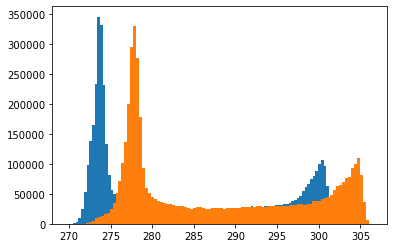

In [4]:
plt.hist(data0K.TAP[:,-1,:,:].values.flatten(),bins=100)
plt.hist(data4K.TAP[:,-1,:,:].values.flatten(),bins=100)

In [5]:
SSTrange0 = np.linspace(271,300,30).astype('int')

In [6]:
Tprof = {}
imin = {}
eps = {}
# Use reference simulation from 270K to 300K to create lookup-table there
# Matching a given NS temperature value to its corresponding temperature profile
for iSST,SST in enumerate(SSTrange0[:-1]):
    print('SST=',SST,'iSST=',iSST,'/',np.size(SSTrange0)-2,'        ',end='\r')
    if iSST==0: mask = (data0K.TAP[:,-1,:,:].values)<SSTrange0[0]
    else: mask = ((data0K.TAP[:,-1,:,:].values)>=SSTrange0[iSST])*((data0K.TAP[:,-1,:,:].values)<SSTrange0[iSST+1])
    Tref = np.mean(np.moveaxis(data0K.TAP.values,1,3)[mask],axis=0)
    Tprof[str(SST)] = Tref
    imin[str(SST)] = np.argwhere((Tref[1:]<Tref[:-1])==True)[-1][0]+1
    tmp = (-(Tref-Tref[-1])/(Tref[-1]-Tref[imin[str(SST)]]))[imin[str(SST)]:]
    eps[str(SST)] = np.maximum(0,np.minimum(1,tmp))

In [7]:
SSTrange4 = np.linspace(300,305,6).astype('int')

In [8]:
# Use reference simulation from 270K to 300K to create lookup-table there
# Matching a given NS temperature value to its corresponding temperature profile
for iSST,SST in enumerate(SSTrange4[:-1]):
    print('SST=',SST,'iSST=',iSST,'/',np.size(SSTrange4)-2,'        ',end='\r')
    mask = ((data4K.TAP[:,-1,:,:].values)>=SSTrange4[iSST])*((data4K.TAP[:,-1,:,:].values)<SSTrange4[iSST+1])
    Tref = np.mean(np.moveaxis(data4K.TAP.values,1,3)[mask],axis=0)
    Tprof[str(SST)] = Tref
    imin[str(SST)] = np.argwhere((Tref[1:]<Tref[:-1])==True)[-1][0]+1
    tmp = (-(Tref-Tref[-1])/(Tref[-1]-Tref[imin[str(SST)]]))[imin[str(SST)]:]
    eps[str(SST)] = np.maximum(0,np.minimum(1,tmp))

In [9]:
SSTrange = np.concatenate((SSTrange0,SSTrange4))

In [10]:
Tprof

{'271': array([175.05305, 175.79523, 168.86584, 188.3044 , 191.08154, 193.59715,
        194.87766, 195.86592, 197.10896, 197.93329, 198.20827, 198.95229,
        200.53038, 203.62352, 208.32057, 213.80965, 219.7647 , 225.57294,
        231.93898, 240.13242, 247.92708, 254.06015, 258.52615, 261.41803,
        263.3411 , 265.13504, 266.7946 , 268.30746, 269.59747, 270.80292],
       dtype=float32),
 '272': array([178.80902, 180.3608 , 172.19281, 190.26031, 192.81566, 194.74995,
        196.19682, 197.18828, 197.97234, 198.60416, 198.89404, 199.69826,
        201.16496, 203.83264, 208.34036, 213.89694, 220.03763, 227.36414,
        235.354  , 243.22276, 250.00821, 256.2507 , 260.86795, 263.77023,
        264.43182, 266.15125, 268.76108, 270.3964 , 271.8086 , 272.101  ],
       dtype=float32),
 '273': array([221.73726, 215.7007 , 203.24884, 221.55614, 217.94537, 216.65402,
        216.46938, 215.93289, 215.25137, 214.969  , 214.38474, 213.1659 ,
        211.97432, 211.97919, 213.318  , 21

In [11]:
pathPKL = '/home/t/Tom.Beucler/SPCAM/CBRAIN-CAM/notebooks/tbeucler_devlog/PKL_DATA/'
hf = open(pathPKL+'2019_11_20_Tlookup.pkl','wb')
Tlookup = {"eps":eps,"imin":imin,"Tprof":Tprof,"SSTrange":SSTrange}
pickle.dump(Tlookup,hf)
hf.close()

# 2) Numpy interpolation layers

In [12]:
#Load profile of convective heating and moistening
it = 205
ilat = 55
ilon = 25
PHQ_test = data0K.PHQ[it,:,ilat,ilon]
TPHYSTND_test = data0K.TPHYSTND[it,:,ilat,ilon]
TAP_test = data0K.TAP[it,:,ilat,ilon]

In [13]:
# Find closest SST
iSST = np.argmin(np.abs(SSTrange-TAP_test.values[-1]))
SST = str(SSTrange[iSST].astype('int'))

In [14]:
# Interpolate the tendencies on reference eps profile
eps_ref = np.linspace(0,1,1001)
TPHYSTND_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=TPHYSTND_test[imin[SST]:][::-1])
PHQ_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=PHQ_test[imin[SST]:][::-1])

Text(0.5, 1.0, 'PHQ')

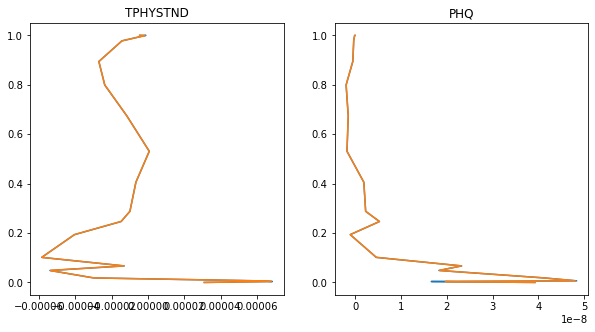

In [15]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(TPHYSTND_test[imin[SST]:][::-1],eps[SST][::-1])
plt.plot(TPHYSTND_testeps,eps_ref)
plt.title('TPHYSTND')

plt.subplot(1,2,2)
plt.plot(PHQ_test[imin[SST]:][::-1],eps[SST][::-1])
plt.plot(PHQ_testeps,eps_ref)
plt.title('PHQ')

In [16]:
# Reinterpolate back
TPHYSTND_back = np.interp(x=eps[SST][::-1],xp=eps_ref,fp=TPHYSTND_testeps)[::-1]
TPHYSTND_back = np.concatenate((np.zeros([imin[SST]],),TPHYSTND_back))

PHQ_back = np.interp(x=eps[SST][::-1],xp=eps_ref,fp=PHQ_testeps)[::-1]
PHQ_back = np.concatenate((np.zeros([imin[SST]],),PHQ_back))

Text(0.5, 1.0, 'PHQ')

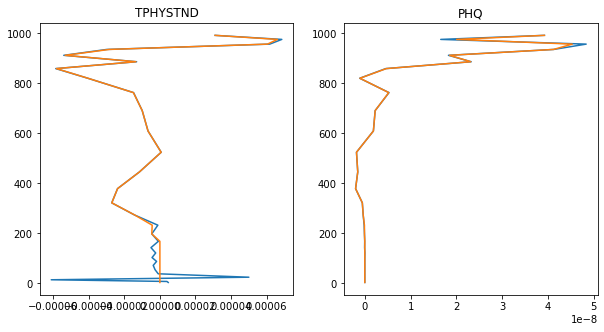

In [17]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(TPHYSTND_test,data0K.lev)
plt.plot(TPHYSTND_back,data0K.lev)
plt.title('TPHYSTND')

plt.subplot(1,2,2)
plt.plot(PHQ_test,data0K.lev)
plt.plot(PHQ_back,data0K.lev)
plt.title('PHQ')

# 3) Tensorflow layers

## 3.1) Forward interpolation layer

In [18]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tfm

In [ ]:
i = searchsorted(xp, x); 
cond(eq(i, 0), left, cond(eq(i, len(xp)), right, 
                          fp[i - 1] + (fp[i] - fp[i - 1]) * (x - xp[i - 1]) / (xp[i] - xp[i - 1])))

In [19]:
tfp.math.interp_regular_1d_grid(
    x,
    x_ref_min,
    x_ref_max,
    y_ref,
    axis=-1,
    fill_value='constant_extension',
    fill_value_below=None,
    fill_value_above=None,
    grid_regularizing_transform=None,
    name=None
)

NameError: name 'x' is not defined

In [ ]:
class MassConsLayer_choice(Layer):
    def __init__(self, inp_sub, inp_div, norm_q, hyai, hybi, lvl_choice, **kwargs):
        """
        Call using ([input, output])
        Assumes
        prior: [PHQ_nores, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Returns
        post(erior): [PHQ, PHCLDLIQ, PHCLDICE, TPHYSTND_nores,
        QRL, QRS, DTVKE, FSNT, FSNS, FLNT, FLNS, PRECT, PRECTEND, PRECST, PRECSTEN]
        Added lvl_choice, a hyper-parameter to choose the level of mass conservation [0-29]
        """
        self.inp_sub, self.inp_div, self.norm_q, self.hyai, self.hybi = \
            np.array(inp_sub), np.array(inp_div), np.array(norm_q), np.array(hyai), np.array(hybi)
        self.lvl_choice = np.int32(lvl_choice)
        # Define variable indices here
        # Input
        self.PS_idx = 300
        self.LHFLX_idx = 303
        # Output
        self.PHQbef_idx = slice(0, self.lvl_choice) # Indices before the residual
        self.PHCLDLIQ_idx = slice(29, 59)
        self.PHCLDICE_idx = slice(59, 89)
        self.PRECT_idx = 212
        self.PRECTEND_idx = 213

        super().__init__(**kwargs)

    def build(self, input_shape):
        super().build(input_shape)

    def get_config(self):
        config = {'inp_sub': list(self.inp_sub), 'inp_div': list(self.inp_div),
                  'norm_q': list(self.norm_q), 'hyai': list(self.hyai),
                  'hybi': list(self.hybi), 'lvl_choice':self.lvl_choice}
        base_config = super().get_config()
        return dict(list(base_config.items()) + list(config.items()))

    def call(self, arrs):
        
        # Find closest SST
        tf.math.argmin
        iSST = tfm.argmin(tfm.abs(SSTrange-TAP_test.values[-1]))
        SST = str(SSTrange[iSST].astype('int'))
        
        # Interpolate the tendencies on reference eps profile
        eps_ref = tf.linspace(0,1,1001)
        TPHYSTND_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=TPHYSTND_test[imin[SST]:][::-1])
        PHQ_testeps = np.interp(x=eps_ref,xp=eps[SST][::-1],fp=PHQ_test[imin[SST]:][::-1])
        
        tfp.math.interp_regular_1d_grid(
    x,
    x_ref_min,
    x_ref_max,
    y_ref,
    axis=-1,
    fill_value='constant_extension',
    fill_value_below=None,
    fill_value_above=None,
    grid_regularizing_transform=None,
    name=None
)
        
        
        inp, prior = arrs

        # 1. Compute dP_tilde
        dP_tilde = compute_dP_tilde(
            inp[:, self.PS_idx],
            self.inp_div[self.PS_idx], self.inp_sub[self.PS_idx],
            self.norm_q, self.hyai, self.hybi
        )

        # 2. Compute vertical cloud water integral
        CLDINT = K.sum(dP_tilde *
                       (prior[:, self.PHCLDLIQ_idx] + prior[:, self.PHCLDICE_idx]),
                       axis=1)

        # 3. Compute water vapor integral minus the water vapor residual
        # Careful with handling the pressure vector since it is not aligned
        # with the prior water vapor vector
        VAPINT = K.sum(dP_tilde[:, self.PHQbef_idx] * prior[:, self.PHQbef_idx], 1) +\
        K.sum(dP_tilde[:, self.lvl_choice+1:30] * prior[:, self.lvl_choice:29], 1)

        # 4. Compute forcing (see Tom's note for details, I am just copying)
        LHFLX = (inp[:, self.LHFLX_idx] * self.inp_div[self.LHFLX_idx] +
                 self.inp_sub[self.LHFLX_idx])
        PREC = prior[:, self.PRECT_idx] + prior[:, self.PRECTEND_idx]

        # 5. Compute water vapor tendency at level lvl_choice as residual
        PHQ_LVL = (LHFLX - PREC - CLDINT - VAPINT) / dP_tilde[:, self.lvl_choice]

        # 6. Concatenate output vector
        post = tf.concat([
            prior[:, self.PHQbef_idx], PHQ_LVL[:, None],
            prior[:, self.lvl_choice:]
        ], axis=1)
        return post

    def compute_output_shape(self, input_shape):
        """Input shape + 1"""
        return (input_shape[0][0], input_shape[0][1] + 1)